In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [59]:
counties = gpd.read_file("OSMB-46184682c1a71852b4f335f9ce651d8857373220.geojson")
counties = counties.loc[counties["admin_level"] == 6] #there are two townships in here for some reason
counties = counties.to_crs(6551)

In [368]:
urban_areas = gpd.read_file("tl_2020_us_uac20/tl_2020_us_uac20.shp")
urban_areas = urban_areas.to_crs(6551)

In [62]:
from sqlalchemy import create_engine
con = create_engine("postgresql://localhost/osm_midwest")  

In [313]:
water = gpd.read_postgis("""
     SELECT 
         way, way_area
     FROM 
         planet_osm_polygon as p
     WHERE 
             (p.natural = "water" OR p.natural='wetland' OR p.natural='bay'
              OR p.landuse='reservoir' OR p.landuse='basin' 
              OR p.water is not null OR p.waterway is not null) 
          AND
              p.way_area > 1e6
    """, con, geom_col='way')  
water = water.to_crs(6551)
water = water.loc[water.intersects(counties.unary_union)]

In [280]:
water_lines = gpd.read_postgis("""
     SELECT 
         *
     FROM 
         planet_osm_line as l
     WHERE 
         l.waterway is not null
    """, con, geom_col='way')  
water_lines = water_lines.to_crs(6551)
water_lines = water_lines.loc[water_lines.intersects(counties.unary_union)]

In [154]:
highways = gpd.read_postgis("""
SELECT 
    highway, way
FROM 
    planet_osm_roads as r
WHERE
    r.highway in ('motorway', 'motorway_link', 'platform', 'primary', 'primary_link', 'secondary', 'secondary_link', 'trunk')
""", con, geom_col="way")
highways = highways.to_crs(6551)

In [416]:
def render_map(bound):
    
    base = bound.plot(ec="k", fc="#b1d8b8")
    
    base = water.clip(bound).way.plot(ax=base)
    
    w_lines = water_lines.clip(bound)
    w_lines.loc[w_lines.waterway == "river"].plot(ax=base, lw=2)
    
    urban_areas.clip(bound).plot(ax=base, color="#f1f1f1")
        
    h = highways.clip(bound)
    for lw, kinds in [(2, ["primary"]), 
                      (1, ["trunk", "primary_link", "motorway", "secondary", "secondary_link"])]:
        h.loc[h.highway.isin(kinds)].plot(ax=base, lw=lw, color="grey")
    bound.plot(ax=base, ec="k", fc="none", zorder=100)
    base.set_axis_off()
    return base
   

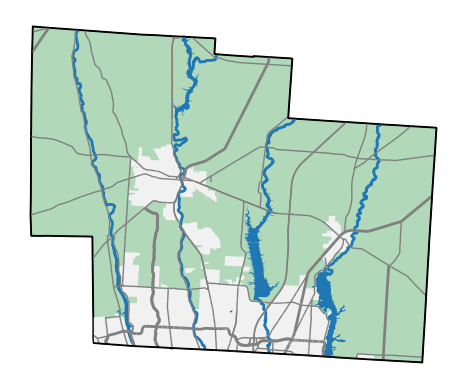

In [422]:
ax = render_map(counties.sample(1))

In [424]:
for name in counties.name:
    ax = render_map(counties.loc[counties.name == name])
    plt.savefig(f"plots/{name.split()[0]}.png", bbox_inches="tight", transparent="true")
    plt.close()

/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site

In [470]:
counties.reset_index()

,index,osm_id,boundary,admin_level,parents,name,local_name,name_en,geometry
0,2,-911314,administrative,6,"-162061,-148838",Paulding County,Paulding County,NaN,"POLYGON ((1333618.294 1145146.939, 1332473.153..."
1,3,-911313,administrative,6,"-162061,-148838",Wood County,Wood County,NaN,"POLYGON ((1588343.572 1220649.879, 1588343.364..."
2,4,-911312,administrative,6,"-162061,-148838",Mahoning County,Mahoning County,NaN,"POLYGON ((2359221.497 1064931.129, 2359238.213..."
3,5,-911311,administrative,6,"-162061,-148838",Meigs County,Meigs County,NaN,"POLYGON ((2018472.775 368979.317, 2022544.598 ..."
4,6,-911310,administrative,6,"-162061,-148838",Summit County,Summit County,NaN,"POLYGON ((2192610.733 1089670.695, 2192631.318..."
...,...,...,...,...,...,...,...,...,...
83,85,-104782,administrative,6,"-162061,-148838",Montgomery County,Montgomery County,NaN,"POLYGON ((1411653.800 704858.288, 1411625.339 ..."
84,86,-104781,administrative,6,"-162061,-148838",Greene County,Greene County,NaN,"POLYGON ((1513544.229 578790.783, 1514603.757 ..."
85,87,-104780,administrative,6,"-162061,-148838",Clinton County,Clinton County,NaN,"POLYGON ((1541656.633 460680.304, 1544024.124 ..."
86,88,-104779,administrative,6,"-162061,-148838",Clermont County,Clermont County,NaN,"POLYGON ((1452913.140 450677.692, 1452914.014 ..."


In [525]:
    print(name, " ", centroid)

Paulding County   POINT (1395154.729490597 1141927.8888248422)
Wood County   POINT (1660001.298875661 1226544.6964026939)
Mahoning County   POINT (2444316.6542040086 1102710.954879844)
Meigs County   POINT (2103949.8888959917 394581.2341040718)
Summit County   POINT (2235235.1057657935 1140106.4396566493)
Richland County   POINT (1958428.2235542526 1010619.2789278721)
Vinton County   POINT (1972667.2349855793 455645.48094709194)
Pike County   POINT (1807577.3812753255 392964.58972601104)
Miami County   POINT (1484542.7443582092 752490.58020735)
Tuscarawas County   POINT (2254173.6131378263 890661.9996096483)
Wayne County   POINT (2137927.247618456 1030990.669022991)
Sandusky County   POINT (1791602.211094979 1223730.617085143)
Morgan County   POINT (2150762.9844754487 590790.6813566523)
Putnam County   POINT (1518116.4175684892 1104986.187135812)
Noble County   POINT (2262063.667317082 644812.3554769261)
Trumbull County   POINT (2446336.206935916 1212944.2217593768)
Stark County   POIN

In [531]:
for name, centroid in zip(counties.name, counties.centroid):
    print(f"\"{name.split()[0]}\": [{centroid.x/5280.0}, {centroid.y/5280.0}],")

"Paulding": [264.2338502823101, 216.27422136834133],
"Wood": [314.39418539311765, 232.3001318944496],
"Mahoning": [462.93876026591073, 208.84677175754624],
"Meigs": [398.475357745453, 74.7312943378924],
"Summit": [423.3399821526124, 215.92924993497144],
"Richland": [370.9144362792145, 191.40516646361215],
"Vinton": [373.6112187472688, 86.2964926036159],
"Pike": [342.34420099911466, 74.42511169053239],
"Miami": [281.16339855269115, 142.51715534230112],
"Tuscarawas": [426.92682067004284, 168.68598477455458],
"Wayne": [404.9104635641015, 195.26338428465738],
"Sandusky": [339.31860058617025, 231.76716232673164],
"Morgan": [407.34147433247136, 111.89217449936596],
"Putnam": [287.5220487819108, 209.27768695754014],
"Noble": [428.42114911308374, 122.12355217366024],
"Trumbull": [463.32125131362045, 229.7242844241244],
"Stark": [432.30226841110306, 194.50457721161624],
"Seneca": [340.0513893476322, 215.64231343475268],
"Wyandot": [330.6577025049149, 196.2753189750357],
"Van": [263.507028930743

array(['Paulding County', 'Wood County', 'Mahoning County',
       'Meigs County', 'Summit County', 'Richland County',
       'Vinton County', 'Pike County', 'Miami County',
       'Tuscarawas County', 'Wayne County', 'Sandusky County',
       'Morgan County', 'Putnam County', 'Noble County',
       'Trumbull County', 'Stark County', 'Seneca County',
       'Wyandot County', 'Van Wert County', 'Medina County',
       'Monroe County', 'Shelby County', 'Scioto County', 'Mercer County',
       'Washington County', 'Portage County', 'Williams County',
       'Lawrence County', 'Guernsey County', 'Athens County',
       'Gallia County', 'Hardin County', 'Jackson County',
       'Defiance County', 'Belmont County', 'Fulton County',
       'Crawford County', 'Jefferson County', 'Allen County',
       'Preble County', 'Darke County', 'Henry County', 'Geauga County',
       'Adams County', 'Huron County', 'Columbiana County',
       'Hancock County', 'Auglaize County', 'Holmes County',
       '

In [509]:
np.vstack((np.array(counties.name), 
           np.array(counties.centroid.x)
         , np.array(counties.centroid.y)))

array([['Paulding County', 'Wood County', 'Mahoning County',
        'Meigs County', 'Summit County', 'Richland County',
        'Vinton County', 'Pike County', 'Miami County',
        'Tuscarawas County', 'Wayne County', 'Sandusky County',
        'Morgan County', 'Putnam County', 'Noble County',
        'Trumbull County', 'Stark County', 'Seneca County',
        'Wyandot County', 'Van Wert County', 'Medina County',
        'Monroe County', 'Shelby County', 'Scioto County',
        'Mercer County', 'Washington County', 'Portage County',
        'Williams County', 'Lawrence County', 'Guernsey County',
        'Athens County', 'Gallia County', 'Hardin County',
        'Jackson County', 'Defiance County', 'Belmont County',
        'Fulton County', 'Crawford County', 'Jefferson County',
        'Allen County', 'Preble County', 'Darke County', 'Henry County',
        'Geauga County', 'Adams County', 'Huron County',
        'Columbiana County', 'Hancock County', 'Auglaize County',
        '

array([1141927.88882484, 1226544.69640269, 1102710.95487984,
        394581.23410407, 1140106.43965665, 1010619.27892787,
        455645.48094709,  392964.58972601,  752490.58020735,
        890661.99960965, 1030990.66902299, 1223730.61708514,
        590790.68135665, 1104986.18713581,  644812.35547693,
       1212944.22175938, 1026984.16767733, 1138591.41493549,
       1036333.68418819, 1046767.33014134, 1136214.21664856,
        632264.96733816,  853677.68944509,  293232.61962308,
        932187.16610172,  531677.32471681, 1156505.48386446,
       1303672.7929508 ,  217940.36170726,  748932.97733   ,
        486115.41760969,  300390.59107519,  971515.35247816,
        371354.2806834 , 1216977.88394181,  737732.99930311,
       1316305.50047708, 1038698.16647075,  873325.28817561,
       1013546.36153386,  641468.18857437,  783950.38856237,
       1218324.5565021 , 1277570.84247315,  309368.88602143,
       1146154.56806374, 1012980.10025148, 1095583.20176291,
        937365.27220698,

In [ ]:
np.st